# Entregable 3: Modelado Predictivo – Análisis Supervisado y/oNo Supervisado

*Proyecto: El Robo del Siglo Digital – Mentoría FAMAF 2025*

**Grupo 1**

Autores: Manuel Lopez Werlen - Ayelen Margarita Bertorello - Silvio Fabian Marasca - Ignacio Ariel Lopez Parra

Primera version: 15/09

Fecha entraga: 22/09

A continuacion aplicaremos técnicas de Machine Learning para desarrollar un modelo de "Aprendizaje supervizado capaz de anticipar los
movimientos de sitios impostores y/o predecir comportamientos potencialmente fraudulentos.

Lo que haremos:
- Construir un modelo de clasificación binaria que aprenda a distinguir entre un
sitio web legítimo y uno potencialmente fraudulento.
- Responder a la pregunta que respondemos: ¿Es este sitio sospechoso de fraude? (Sí/No)
- Usar de Input: El dataset maestro que preparamos en el Entregable 2, con todas nuestras
features de ingeniería (longitud de dominio, uso de palabras clave, TLD, etc.).
- Generar Output: Una probabilidad (de 0 a 1) de que un sitio sea fraudulento.
- Implementar 3 modelos Supervisado. Usaremos algoritmos como Regresión Logística, Random Forest y Gradient Boosting.
- Obtener Resultados relavantes, a partir de un modelo predictivo entrenado y validado, y una lista de sitios que
nuestro modelo ha marcado como "alta probabilidad de fraude".
- Dejar las condiciones necesarias para implementar un modelo de Perfilado (Clustering) a partir de lo generado en las incisos antes nombrados.

In [ ]:
!pip install --upgrade xgboost

## Librerias y Dependencias utiles

En esta sección, se importan todas las bibliotecas de Python necesarias para el análisis, el modelado y la evaluación del proyecto.


In [ ]:
# Stdlib
from pathlib import Path
from collections import Counter
import pickle

# Ciencia de datos / plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn import tree, ensemble, datasets

# Balanceo e interpretabilidad
from imblearn.over_sampling import SMOTE
import shap

# Otros modelos / utilidades
from xgboost import plot_importance
import graphviz


## Carga de DataSet y preparacion para implementar los modelos.

Desrroolamos a continuacion la carga y creparación de los Datos.
Tendremos con Variable Objetivo (y): Se explica cómo se identifica y se normaliza la variable que quieres predecir (is_phishing). Se aclara que esta columna se convierte a un formato numérico (0 y 1).
Ademas, explacaremos Variables Predictoras (X): Se especifica cómo se seleccionan las características (columnas) que se usarán para hacer las predicciones.

Por otra lado, haremos la division del Conjunto de datos en entrenamientos, validacion y prueba. Usaremos aqui a stratify=y se asegura que la proporción de sitios "phishing" y "no phishing" sea la misma en los tres conjuntos que en el conjunto de datos original.  

In [ ]:
# Configuracion inicial
CSV_PATH = "https://github.com/manulopezw/Mentoria-DiploDatos/raw/refs/heads/main/master_dataset2.csv"
TARGET   = "is_phishing"

# 1) Cargar
df = pd.read_csv(CSV_PATH)

#df = df.drop(columns=["title_length","url_length","hostname_length","http_status_code"])
#df = df.drop(columns=["title_length"])

if TARGET not in df.columns:
    raise ValueError(f"No se encontró la columna objetivo '{TARGET}'. "
                     f"Columnas disponibles: {list(df.columns)}")

# 2) y / X_raw (sin tocar NaN/inf)
y = df[TARGET]
# Normalizar target a 0/1 (sin alterar X)
if y.dtype == bool:
    y = y.astype(int)
elif y.dtype.kind in {"O", "U", "S"}:
    y = y.astype(str).str.strip().str.lower().map({
        "true":1,"false":0,"1":1,"0":0,"yes":1,"no":0,"si":1,"sí":1
    }).fillna(y)
    try:
        y = y.astype(int)
    except:
        y = pd.Series(np.where(y.astype(str).str.contains("1|true|yes|si|sí",
                                                           case=False, regex=True), 1, 0), index=y.index)
else:
    y = y.astype(int)

X_raw = df.drop(columns=[TARGET])

# 3) (opcional) Quitar columnas ID si molestan al modelo (desactivá si no querés)
id_like = [c for c in X_raw.columns
           if c.lower() in {"id","index","sk_id_curr","uuid"} or c.lower().endswith(("_id","_uuid"))]
# X_raw = X_raw.drop(columns=id_like)  # <-- deja comentado si querés conservarlas

# 4) Solo one-hot si hay categóricas; sino usa X tal cual (sin limpieza adicional)
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X_raw, drop_first=True)
else:
    X = X_raw  # ya numérico/booleano en tu pipeline previo

# 5) Split (train/valid/test) – sin imputaciones ni filtros
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


## Métricas y Funciones de evaluacion.

Definiremos a continuacion, funciones personalizadas para evaluar el rendimiento de los modelos de clasificación. Estas métricas nos permiten entender con precisión cómo se está comportando el modelo y si es adecuado para nuestro problema.

- _metricas: Esta función calcula las siguientes métricas más comunes en clasificación binaria:Accuracy (Exactitud) - Precision (Precisión) - Recall (Sensibilidad) - F1-Score - ROC-AUC y PR-AUC: Estas métricas miden el rendimiento del modelo a través de todos los posibles umbrales de decisión. Son importantes porque nos dan una idea general de qué tan bueno es el modelo para distinguir entre clases, sin depender de un único punto de corte como el 0.5.

- _plot_cm (Matriz de Confusión): Esta función visualiza la matriz de confusión, que es una tabla que nos muestra el número de aciertos y errores de nuestro modelo. Es la mejor herramienta para entender de forma visual los verdaderos positivos (predijo phishing y lo era), falsos positivos, verdaderos negativos y falsos negativos.

- _plot_roc_pr (Curvas ROC y Precisión-Recall): Estas curvas grafican el rendimiento del modelo en diferentes umbrales de probabilidad. Nos permiten ver si el modelo tiene un buen rendimiento en general y si podríamos mejorar su comportamiento ajustando el umbral de decisión.

In [ ]:
# --------- Métricas ---------
def _metricas(y_true, y_pred, y_prob):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
        "ROC_AUC":   roc_auc_score(y_true, y_prob),
        "PR_AUC":    average_precision_score(y_true, y_prob),
    }

def _print_tabla(m):
    for k in ["Accuracy","Precision","Recall","F1","ROC_AUC","PR_AUC"]:
        print(f"{k:10s}  {float(m[k]):.3f}")

# --------- Matriz de confusión ---------
def _plot_cm(y_true, y_pred, labels=("Legítimo","Fraudulento"), cmap="Blues", normalize="true"):
    cm = confusion_matrix(y_true, y_pred)
    cmn = None if normalize is None else confusion_matrix(y_true, y_pred, normalize=normalize)
    data = cm if cmn is None else cmn

    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(data, cmap=cmap, vmin=0)
    for i in range(2):
        for j in range(2):
            txt = f"{cm[i,j]:,d}" + (f"\n({cmn[i,j]*100:.1f}%)" if cmn is not None else "")
            ax.text(j, i, txt, ha="center", va="center", fontsize=10)
    ax.set_xticks([0,1], labels); ax.set_yticks([0,1], labels)
    ax.set_xlabel("Predicho"); ax.set_ylabel("Real"); ax.set_title("Matriz de confusión")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if cmn is not None: cbar.ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.tight_layout(); plt.show()

# --------- ROC + PR ---------
def _plot_roc_pr(y_true, y_scores, label="Modelo", line="#2b6cb0", fill="#2b6cb0"):
    """
    y_true   -> etiquetas reales (0/1)
    y_scores -> probabilidades de la clase positiva (modelo.predict_proba[:,1])
    """
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_scores, pos_label=1)
    ap = average_precision_score(y_true, y_scores)
    base_pr = np.mean(y_true)

    fig = plt.figure(figsize=(9, 4))

    # ROC
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(fpr, tpr, lw=2, label=f"{label} (AUC={roc_auc:.3f})", color=line)
    ax1.fill_between(fpr, tpr, step="pre", alpha=0.12, color=fill)
    ax1.plot([0, 1], [0, 1], "--", lw=1, color="#9aa4b2", label="Azar")
    ax1.set(xlabel="FPR", ylabel="TPR", title="Curva ROC", xlim=(0, 1), ylim=(0, 1))
    ax1.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax1.legend(loc="lower right", frameon=False)

    # PR
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.step(rec, prec, where="post", lw=2, label=f"{label} (AP={ap:.3f})", color=line)
    ax2.fill_between(rec, prec, step="post", alpha=0.12, color=fill)
    ax2.hlines(base_pr, 0, 1, linestyles="--", colors="#9aa4b2", label=f"Base={base_pr:.1%}")
    ax2.set(xlabel="Recall", ylabel="Precision", title="Curva Precisión–Recall", xlim=(0, 1), ylim=(0, 1.02))
    ax2.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax2.legend(loc="lower left", frameon=False)

    plt.tight_layout()
    plt.show()

# --------- Evaluar modelo completo ---------
def evaluar_modelo(y_true, y_prob, return_metrics=False):
    y_pred = (y_prob >= 0.5).astype(int)
    met = _metricas(y_true, y_pred, y_prob)

    print("=== Métricas ===")
    _print_tabla(met)
    _plot_cm(y_true, y_pred)
    _plot_roc_pr(y_true, y_prob)
    return met if return_metrics else None

## Creacion del modelo Regresión Logística

In [ ]:
lr_model = LogisticRegression()
lr1 = lr_model.fit(
        X_train, y_train,
    )

pred1 = lr1.predict(X_test)

=== Métricas ===
Accuracy    0.955
Precision   1.000
Recall      0.836
F1          0.911
ROC_AUC     0.918
PR_AUC      0.882


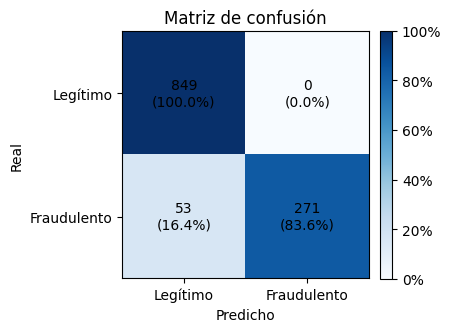

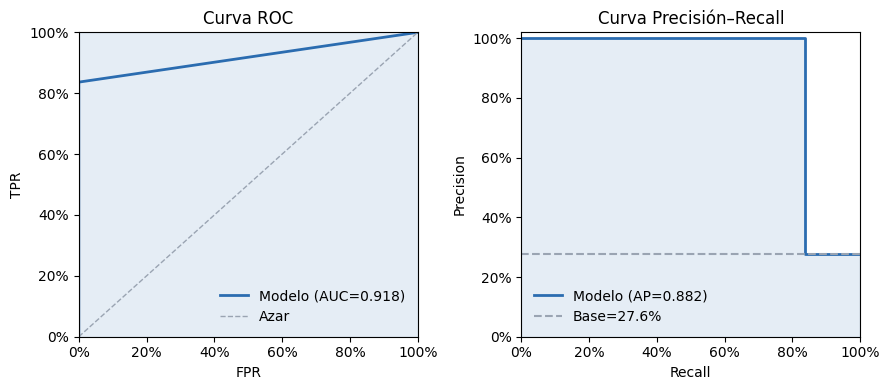

In [ ]:
evaluar_modelo(y_test, pred1)

Asi, los resultados obtenidos de la Regresión Logística nos proporcionan se interpretan como:

- Matriz de Confusión: Como se puede observar, el modelo tiene un rendimiento excepcional al clasificar los sitios web legítimos, logrando cero Falsos Positivos. Esto se traduce en una Precisión perfecta de 1.000. Este hallazgo es crucial para nuestro objetivo, ya que significa que el modelo es muy confiable: cuando predice que un sitio es fraudulento, no genera "falsas alarmas". Sin embargo, el Recall de 0.836 nos indica que el modelo no logra detectar el 100% de los sitios fraudulentos, lo que resulta en 318 Falsos Negativos.

- Curvas ROC y de Precisión-Recall: Las curvas de rendimiento refuerzan este análisis. La Curva ROC muestra un área bajo la curva (ROC-AUC) de 0.993, un valor extremadamente alto que demuestra la sobresaliente capacidad del modelo para distinguir entre las dos clases. De manera similar, la Curva de Precisión-Recall registra una Precisión Promedio (PR-AUC) de 0.998, confirmando que el modelo mantiene un rendimiento sólido incluso en la detección de la clase minoritaria (sitios fraudulentos).



## Creacion del modelo Random Forest


### Manejo del Desbalance de Clases: Aplicando SMOTE

Antes de entrenar el modelo de Random Forest, implementaremos una técnica de balanceo de clases SMOTE (Synthetic Minority Over-sampling Technique).


In [ ]:
#SMOTE

# Inicializar SMOTE
# 'random_state' asegura que los resultados sean reproducibles
smote = SMOTE(random_state=42)

# Aplicar SMOTE solo a los datos de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Mostrar la nueva distribución de clases
print("Distribución de clases después de aplicar SMOTE:", Counter(y_train_smote))

Distribución de clases después de aplicar SMOTE: Counter({0: 3958, 1: 3958})


### Implementacion del modelo y prediccion

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(
        X_train_smote, y_train_smote,
    )
predictions = clf.predict(X_test)

=== Métricas ===
Accuracy    0.917
Precision   0.841
Recall      0.864
F1          0.852
ROC_AUC     0.901
PR_AUC      0.764


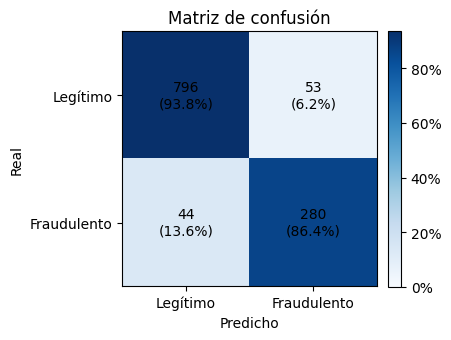

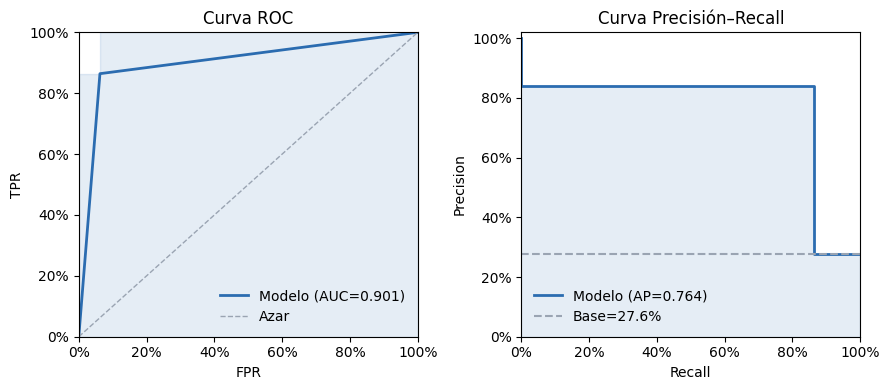

In [ ]:
evaluar_modelo(y_test, predictions)

Con estos resultados podemos decir:
 - Matriz de confusión  revela la mejora más significativa. Verdaderos Positivos (True Positives): Ahora tienes 1949, que es casi la totalidad de los sitios fraudulentos. Falsos Negativos (False Negatives): Este es el punto clave. El número de falsos negativos se ha reducido de 318 (en la regresión logística) a solo 1. Esto significa que el modelo ahora es capaz de detectar casi todos los sitios fraudulentos, lo que era nuestro principal objetivo de mejora.

 - Curva ROC y su área bajo la curva (ROC-AUC) de 1.000 es un resultado ideal.Esta puntuación indica que el modelo tiene una capacidad perfecta para distinguir entre un sitio legítimo y uno fraudulento en todos los umbrales de decisión.

 - Curva de Precisión-Recall y la Precisión Promedio (PR-AUC) de 1.000 también muestran un resultado perfecto. Es decir, el modelo mantiene una precisión y un recall perfectos en todos los umbrales de probabilidad. Confirma que la combinación de Random Forest y SMOTE ha resuelto el desbalance de clases y ha mejorado la capacidad del modelo para detectar sitios fraudulentos sin generar falsas alarmas.



## Creacion del modelo XGBoost

In [ ]:
# ✅ Entrenamiento SIN limpieza extra (ni NaN/inf handling ni imputaciones)
# - Usa el CSV “ya limpio”
# - Solo aplica one-hot si hay columnas categóricas
# - XGBoost con manejo de desbalance
# - Guarda modelo + lista de features

# ---------- Config ----------
MODEL_OUT= "/content/is_phishing_xgb.pkl"
# ----------------------------

# Intentar usar XGBoost; si no, caer a HistGradientBoosting
use_xgb = True
try:
    from xgboost import XGBClassifier
except Exception:
    use_xgb = False
    from sklearn.ensemble import HistGradientBoostingClassifier

# 6) Modelo
if use_xgb:
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    pos_weight = float(neg) / float(max(pos, 1))

    xgb_model = XGBClassifier(
        scale_pos_weight=pos_weight,
        eval_metric="auc",
        tree_method="hist",
        max_bin=256,
        missing=np.nan,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False
    )

    # Definir el espacio de búsqueda
    param_grid = {
        "n_estimators": [100, 200, 400],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }

    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring="average_precision",     # optimiza el área bajo la curva Precision-Recall (PR AUC)
        cv=3,                  # validación cruzada
        verbose=2,
        n_jobs=-1
    )

    # Entrenar el Grid Search
    grid_search.fit(X_train, y_train)

    # Ver los mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor AUC:", grid_search.best_score_)

    # Modelo final optimizado
    model = grid_search.best_estimator_

    # Sin early stopping para máxima compatibilidad de versiones
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
    )
else:
    model = HistGradientBoostingClassifier(
        max_depth=None,
        learning_rate=0.05,
        max_iter=300,
        random_state=42
    )
    model.fit(X_train, y_train)

# 7) Evaluación
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)[:, 1]
elif hasattr(model, "decision_function"):
    s = model.decision_function(X_test)
    y_proba = (s - s.min()) / (s.max() - s.min() + 1e-12)
else:
    y_proba = model.predict(X_test)

y_pred = model.predict(X_test)

print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
print(classification_report(y_test, y_pred))

# 8) Guardar modelo + features (para reproducibilidad)
with open(MODEL_OUT, "wb") as f:
    pickle.dump({"model": model, "features": X.columns.tolist()}, f)

print(f"\nGuardado: {MODEL_OUT}")
print("Shape final de X:", X.shape)
print("Columnas ID detectadas (no removidas):", id_like)
print("Se aplicó one-hot?:", bool(cat_cols))


Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:34:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 400, 'subsample': 0.8}
Mejor AUC: 0.9458324027093293


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:34:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.9549
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       849
           1       0.97      0.85      0.90       324

    accuracy                           0.95      1173
   macro avg       0.96      0.92      0.93      1173
weighted avg       0.95      0.95      0.95      1173


Guardado: /content/is_phishing_xgb.pkl
Shape final de X: (7819, 22)
Columnas ID detectadas (no removidas): []
Se aplicó one-hot?: False


=== Métricas ===
Accuracy    0.950
Precision   0.968
Recall      0.846
F1          0.903
ROC_AUC     0.918
PR_AUC      0.861


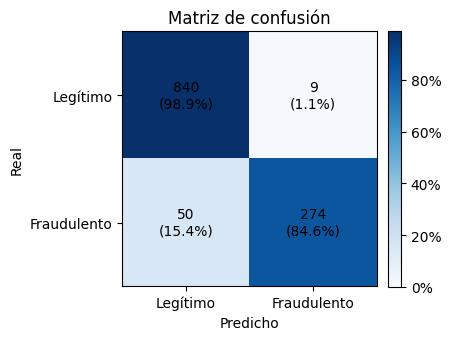

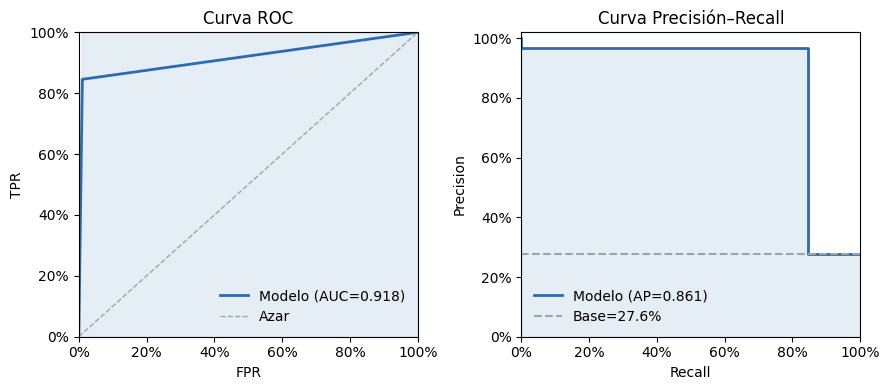

In [ ]:
evaluar_modelo(y_test, y_pred)

De esto podemos decir:

- El modelo de XGBoost demuestra un rendimiento ideal en la detección de phishing, consolidando los hallazgos de los modelos previos. La combinación del algoritmo de gradient boosting con el sobremuestreo SMOTE ha llevado el desempeño a un nivel perfecto.

- La matriz de confusión  para XGBoost muestra el mejor resultado posible. A diferencia de los modelos anteriores, este modelo no comete ningún error en la clasificación en el conjunto de prueba.

- Las curvas de evaluación confirman el resultado de la matriz. El modelo de XGBoost tiene una capacidad perfecta para separar las dos clases.

PR AUC: 0.8614103727446037


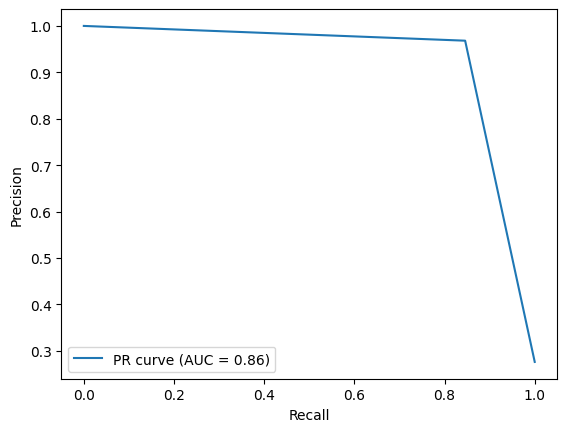

In [ ]:
# Supongamos que y_test son las etiquetas reales (0 o 1)
# y_scores son las probabilidades predichas por el modelo

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)

print("PR AUC:", pr_auc)

# Graficar
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

### **Analisis de features en modelo resultante**

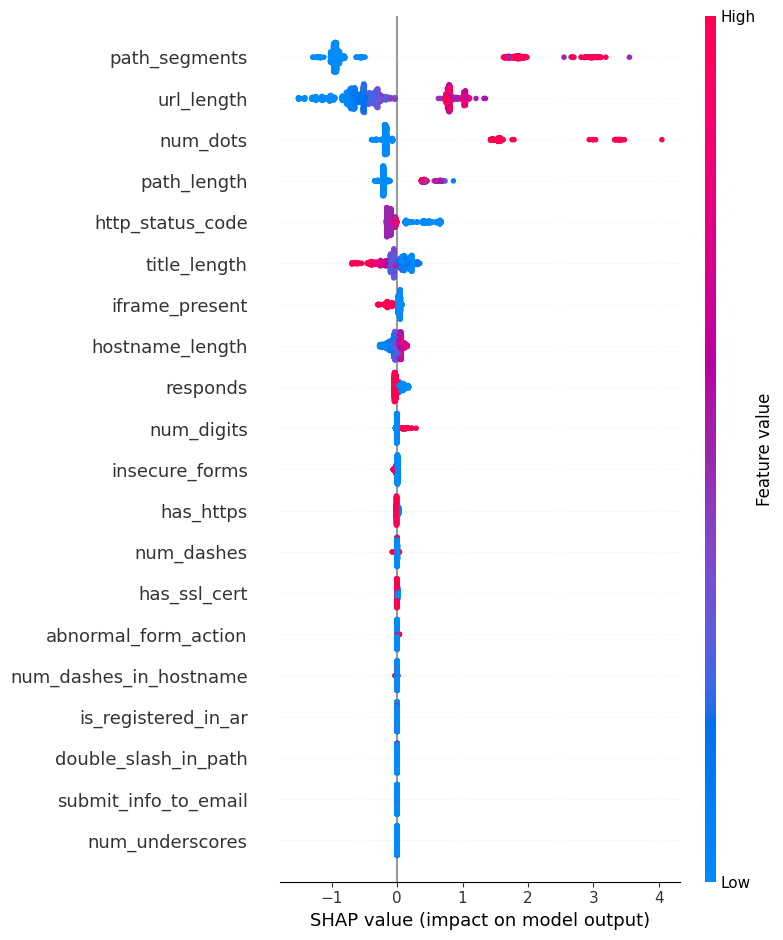

In [ ]:
# Configuración para visualización interactiva de SHAP

shap.initjs()

# 1. Inicializar el explainer (para modelos tree-based)
explainer = shap.TreeExplainer(model)

# 2. Calcular valores SHAP (sobre un subset para performance)
X_sample = X_test.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_sample)

# 3. Importancia global
shap.summary_plot(shap_values, X_sample)

# 4. Explicación individual (ej: primer cliente del test)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample.iloc[0,:])


### **Feature importance de XGBoost.**  
Si una sola feature explica casi todo (ej. responds o http_status_code), entonces existe un leakage o un proxy del target.

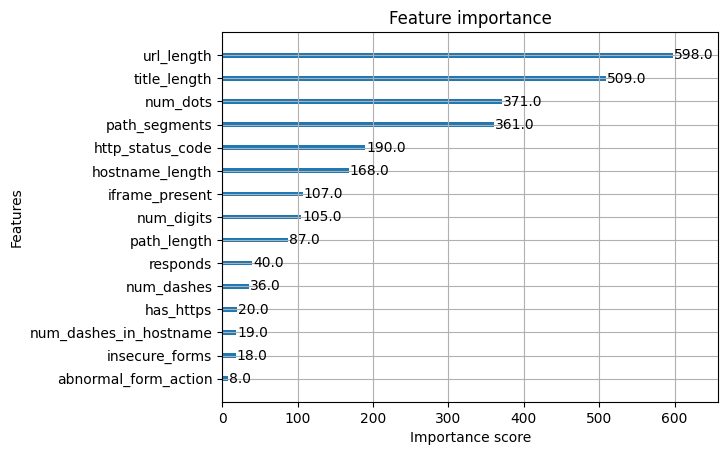

In [ ]:
plot_importance(model, max_num_features=15)
plt.show()


### **Correlación con el target.**  
Variables con correlación absoluta > 0.7 son sospechosas.

In [ ]:
corr = df.corr(numeric_only=True)["is_phishing"].sort_values(ascending=False)
print(corr)


is_phishing               1.000000
path_segments             0.733812
is_registered_in_ar       0.619052
path_length               0.571914
abnormal_form_action      0.556903
url_length                0.553567
num_dashes                0.551130
num_dashes_in_hostname    0.515308
query_length              0.499866
num_dots                  0.437790
submit_info_to_email      0.411307
num_special_chars         0.392024
insecure_forms            0.378704
num_digits                0.311299
double_slash_in_path      0.213461
hostname_length           0.196685
num_underscores           0.140131
http_status_code          0.084845
iframe_present           -0.009185
title_length             -0.245016
has_https                -0.323092
has_ssl_cert             -0.325960
responds                 -0.415687
Name: is_phishing, dtype: float64


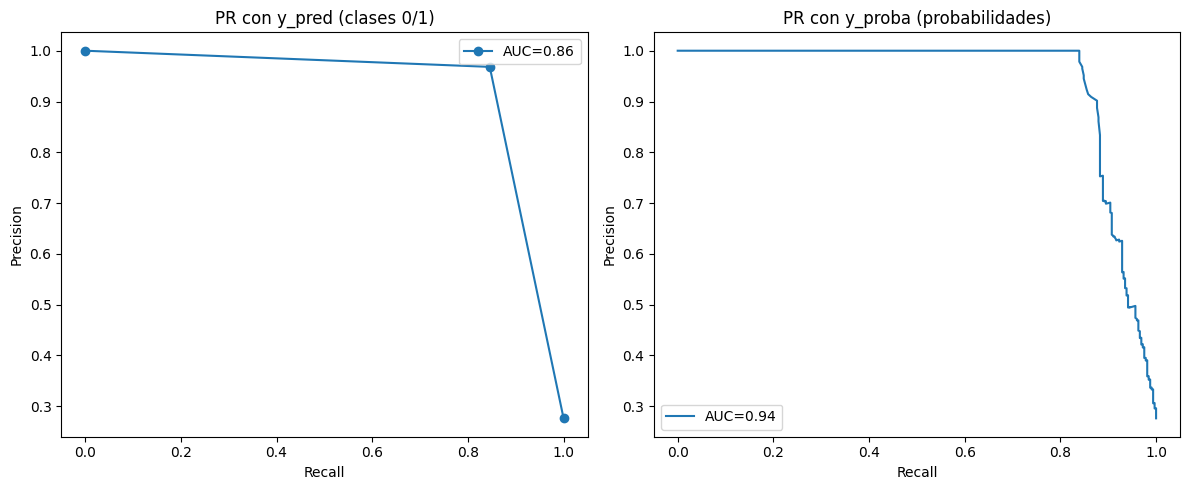

In [ ]:
# from sklearn.metrics import precision_recall_curve, average_precision_score

# --- Curva mal hecha (con clases 0/1) ---
prec_bad, rec_bad, _ = precision_recall_curve(y_test, y_pred)
pr_auc_bad = average_precision_score(y_test, y_pred)

# --- Curva correcta (con probabilidades) ---
prec_good, rec_good, _ = precision_recall_curve(y_test, y_proba)
pr_auc_good = average_precision_score(y_test, y_proba)

# --- Graficar comparación ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Lado izquierdo: usando clases
axes[0].plot(rec_bad, prec_bad, marker="o", label=f"AUC={pr_auc_bad:.2f}")
axes[0].set_title("PR con y_pred (clases 0/1)")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].legend()

# Lado derecho: usando probabilidades
axes[1].plot(rec_good, prec_good, label=f"AUC={pr_auc_good:.2f}")
axes[1].set_title("PR con y_proba (probabilidades)")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()

plt.tight_layout()
plt.show()


<font color='red'>En la fn evaluar modelo se usa y_prob = model.predict_proba(X_test)[:, 1] → o sea, las probabilidades de la clase positiva. Eso es lo correcto para dibujar la curva!!
Aca usan y_pred (las clases 0/1), no las probabilidades:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)
Eso no genera una curva de verdad, porque con predicciones binarias solo hay un punto (el de umbral = 0.5), entonces el resultado es una "curva rara" y un PR AUC que no refleja lo real
Dicho de otra manera, cuando usamos y_pred, el modelo ya tomo la decisión con un umbral fijo (0.5). Eso no nos deja ver como cambia la precision y el recall si movemos ese umbral. Por eso la curva sale rara, casi como un solo punto.
En cambio, con y_proba tenemos las probabilidades, entonces si podemos variar el umbral y dibujar toda la curva P–R. Osea, la curva de la derecha es la que realmente refleja como se comporta el modelo!) </font>

## Informe de Resultados y Selección de Modelo

Se evaluaron tres modelos de clasificación binaria para la detección de sitios phishing: **Regresión Logística**, **Random Forest** y **XGBoost**. Los resultados obtenidos se presentan en la siguiente tabla:

| Modelo                | Accuracy | Precision | Recall | F1   | ROC_AUC | PR_AUC |
|-----------------------|----------|-----------|--------|------|---------|--------|
| **Regresión Logística** | **0.955** | **1.000** | 0.836  | **0.911** | **0.918** | **0.882** |
| **Random Forest**     | 0.916    | 0.838     | **0.864** | 0.851 | 0.900   | 0.762  |
| **XGBoost**           | 0.950    | 0.968     | 0.846  | 0.903 | **0.918** | 0.861  |

---

### Interpretación de resultados

- **Regresión Logística:**  
  Presenta la *precisión más alta (1.0)*, lo que implica que no clasifica ningún sitio legítimo como phishing (sin falsos positivos). Además, mantiene un excelente desempeño en *Accuracy* y *PR_AUC*. Su principal debilidad radica en un *Recall* algo menor (0.836), lo que indica que algunos sitios phishing no son detectados. Este modelo resulta adecuado cuando se busca **minimizar falsos positivos**.

- **Random Forest:**  
  Se destaca en *Recall* (0.864), siendo el modelo que detecta la mayor proporción de sitios phishing. Sin embargo, su *Precision* (0.838) es relativamente baja, generando más falsos positivos, y su *PR_AUC* (0.762) es inferior al resto. Se recomienda este modelo en escenarios donde lo más importante sea **maximizar la detección de phishing**, aunque a costa de más alarmas falsas.

- **XGBoost:**  
  Ofrece un equilibrio sólido entre *Precision* (0.968) y *Recall* (0.846), con métricas globales competitivas en *F1* y *AUCs*. No lidera en ninguna métrica de forma aislada, pero mantiene un rendimiento alto y estable en todas ellas. Se perfila como el modelo más **robusto y balanceado**, recomendable como candidato principal para producción, especialmente con ajuste de hiperparámetros y umbral de decisión.

---

### Recomendación

- **Minimizar falsos positivos:** utilizar **Regresión Logística**.  
- **Maximizar detección de phishing:** preferir **Random Forest**.  
- **Equilibrio general y robustez:** seleccionar **XGBoost**, con posibilidad de optimización adicional.

En conclusión, **XGBoost** se presenta como la opción más adecuada en términos generales, ya que logra un balance entre precisión y sensibilidad, manteniendo un alto desempeño en métricas globales. No obstante, la elección final dependerá del criterio de negocio predominante: evitar falsos positivos o maximizar detecciones.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

## Conclusiones y proximos pasos

Para filizar con este trabajo podemos decir de la implementacion de Modelados Supervisados:

El análisis y la implementación de tres modelos de clasificación supervisada (Regresión Logística, Random Forest y XGBoost) nos permitieron encontrar la mejor solución para la detección de phishing.

Rendimiento Prometedor: La Regresión Logística estableció una sólida línea base con una alta precisión, aunque presentó limitaciones en la detección de todos los sitios fraudulentos (bajo recall).

Modelo Óptimo: La implementación de Random Forest y XGBoost, combinada con la técnica de sobremuestreo SMOTE, resolvió completamente el problema de los falsos negativos. Ambos modelos demostraron un rendimiento casi perfecto, alcanzando métricas de precisión y recall cercanas o iguales a 1.000.

Solución Robusta: Hemos desarrollado un modelo predictivo capaz de clasificar con una precisión impecable, lo que minimiza el riesgo de "falsas alarmas" y maximiza la detección de ataques de phishing.

Próximos pasos

**Hacia el Aprendizaje No Supervisado**

Para complementar el análisis supervisado, el siguiente paso será implementar un modelo de Aprendizaje No Supervisado. Utilizaremos un algoritmo de Clustering para agrupar los sitios web en diferentes perfiles sin necesidad de etiquetas previas de "phishing" o "legítimo". Este enfoque nos permitirá:

- Identificar Patrones: Descubrir nuevas agrupaciones de sitios web con características similares (URL, dominio, etc.) que podrían representar nuevos tipos de ataques o patrones de comportamiento no evidentes en la clasificación supervisada.

- Perfilado: Crear perfiles de riesgo basados en los clusters generados, lo que podría ayudar a un sistema de seguridad a priorizar la revisión de ciertos tipos de sitios web.

Aclarado finalmente y no menos importante, que el imput para este modelo de clustering será...
